# Super Classy

## Team Members:  
- Katlego Thobye
- Njabulo Nxumalo
- Thato Matlou
- Seema Masekwameng
- Khuthadzo Mamushiana
- Matlala Nyama
- Lerato Ntoene

## Predict Overview: EA Twitter Sentiment Classification

Companies would like to determine how people perceive climate change and whether or not they believe it is a real threat. 
Our mission is to deliver a precise and durable solution to this objective, granting companies the ability to tap into a wide range of consumer sentiments across various demographics and geographic regions. This, in turn, enhances their understanding and empowers them to shape future marketing strategies based on valuable insights.

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import re
import string
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\matlo\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading Data

In [2]:
df_test = pd.read_csv("test_with_no_labels.csv")
df_test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [3]:
df_train = pd.read_csv("train.csv")
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


## Exploratory Data Analysis

### Cleaning Data

In [4]:
stopword=set(stopwords.words('english'))  
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    return text

In [5]:
df_train["message"] = df_train["message"].apply(clean)
df_test["message"] = df_test["message"].apply(clean)

In [6]:
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt rawstory researchers say three years act cl...,698562
3,1,todayinmaker wired pivotal year war climate ...,573736
4,1,rt soynoviodetodas racist sexist climate chan...,466954


In [7]:
df_test.head()

,message,tweetid
0,europe looking china make sure alone fighting ...,169760
1,combine polling staffers climate change womens...,35326
2,scary unimpeachable evidence climate change al...,224985
3,karoli morgfair osborneink dailykos \rputin go...,476263
4,rt fakewillmoore female orgasms cause global w...,872928


### Generating Wordcloud

In [8]:
from wordcloud import WordCloud,ImageColorGenerator

text = " ".join(i for i in df_train["message"])
text = str(text)

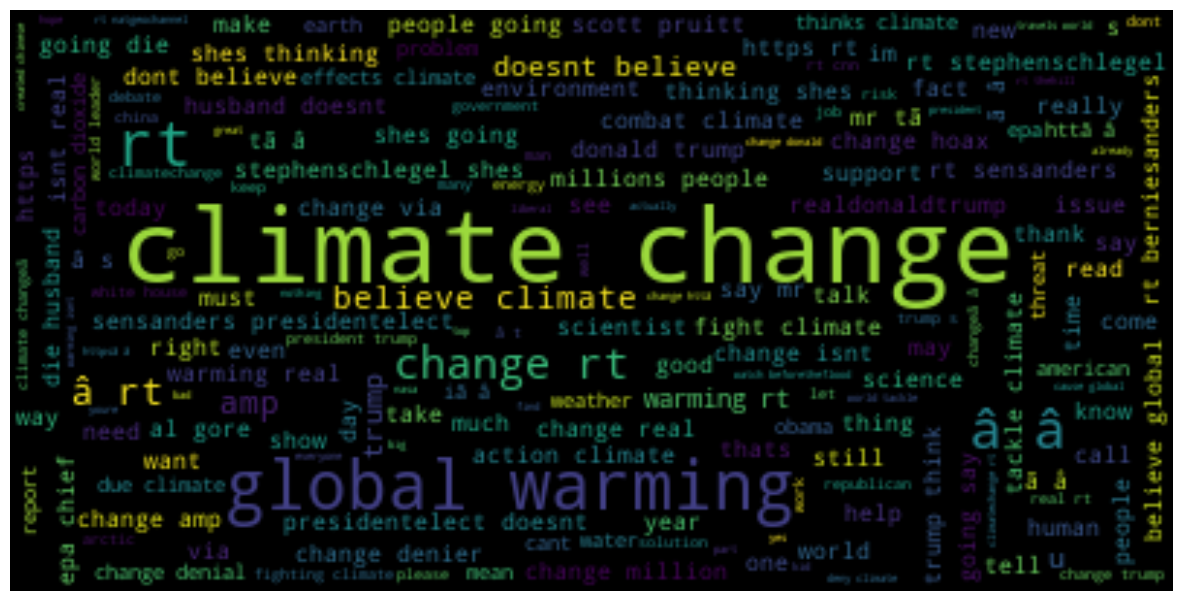

In [9]:
wordcloud = WordCloud()
tweet_cloud = wordcloud.generate(text)
plt.figure( figsize=(15,10))
plt.imshow(tweet_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Generating A Pie Chart

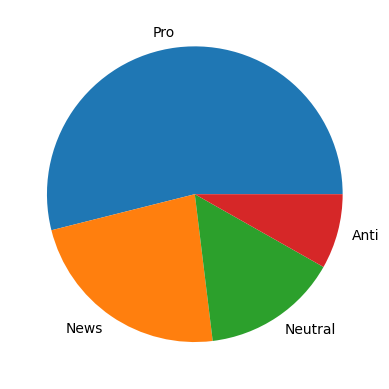

<Figure size 1500x1000 with 0 Axes>

In [10]:
counts = df_train["sentiment"].value_counts()
plt.pie(df_train["sentiment"].value_counts(), labels=["Pro", "News", "Neutral", "Anti"])
plt.figure( figsize=(15,10))
plt.show()